In [9]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [10]:
# built-in libraries
import os
import sys
from itertools import combinations
from collections import defaultdict
import time
import pprint
import copy
from functools import reduce

# external dependencies
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as onp
from tqdm.notebook import tqdm
import jax.numpy as jnp

import multidms
%matplotlib inline

# Data Summary Stats

First load in the data and do a little cleanup

In [11]:
C19 = pd.read_csv("../data/CYP2C19_abundance.csv")
C9 = pd.read_csv("../data/CYP2C9_abundance.csv")

append df's and add condition id, rename for MultiDmsData

In [12]:
rename_map = {
    "variant" : "aa_substitutions"
}
func_score_df = pd.concat(
    [
        C19.assign(condition="C19"), 
        C9.assign(condition="C9")
    ]
).rename(rename_map,axis=1).reset_index(drop=True)

remove 'syn' mutants

In [13]:
func_score_df = func_score_df[~func_score_df.aa_substitutions.str.contains("syn")]

conform 'X' -> '*' for stop codon variants

In [14]:
func_score_df = func_score_df.assign(aa_substitutions = func_score_df.aa_substitutions.str.replace("X", "*"))

add log fold change of weighted average.

In [15]:
func_score_df = func_score_df.assign(log_fold_wa = onp.log2(func_score_df.weighted_average / func_score_df.wt_wa))

In [16]:
func_score_df

,replicate,sort,barcode,weighted_average,total_reads,freq,type,med_nonsense,wt_wa,abundance_score,aa_substitutions,start,position,end,condition,log_fold_wa
0,Rep2,1.0,AAAAAAAACTACGTTCCA,0.844684,234,0.000008,missense,0.291621,0.826506,1.033983,S162R,S,162,R,C19,0.031385
1,Rep2,1.0,AAAAAAAATCCTAGCCGT,0.563894,937,0.000039,missense,0.291621,0.826506,0.509032,D373R,D,373,R,C19,-0.551601
2,Rep2,1.0,AAAAAAAATTTTGAAAGA,0.681836,959,0.000038,missense,0.291621,0.826506,0.729530,D360K,D,360,K,C19,-0.277602
3,Rep2,1.0,AAAAAAACTATTGACTTC,0.751838,217,0.000008,missense,0.291621,0.826506,0.860404,L71G,L,71,G,C19,-0.136604
4,Rep2,1.0,AAAAAAATACAGGTTAAT,0.304310,215,0.000017,nonsense,0.291621,0.826506,0.023724,E274*,E,274,X,C19,-1.441484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541398,Rep3,NaN,TTTTTTTTGAAAGTCAAG,0.706138,188,0.000070,missense,0.423188,0.701742,1.015779,K247A,K,247,A,C9,0.009008
541399,Rep3,NaN,TTTTTTTTGCCAACGAAG,0.647242,166,0.000065,missense,0.423188,0.701742,0.804345,D191T,D,191,T,C9,-0.116636
541400,Rep3,NaN,TTTTTTTTGTAATTCTTG,0.692603,103,0.000038,missense,0.423188,0.701742,0.967191,Q193L,Q,193,L,C9,-0.018912
541401,Rep3,NaN,TTTTTTTTGTACGTACTT,0.496281,104,0.000044,missense,0.423188,0.701742,0.262400,G332S,G,332,S,C9,-0.499785


Summary stats of quantitative columns

In [17]:
func_score_df.describe()

,sort,weighted_average,total_reads,freq,med_nonsense,wt_wa,abundance_score,position,log_fold_wa
count,421147.000000,519020.000000,519020.000000,5.190200e+05,519020.000000,519020.000000,519020.000000,519020.000000,519020.000000
mean,1.494098,0.626921,438.002173,4.301402e-05,0.326916,0.750214,0.709008,232.082633,-0.313643
std,0.499966,0.169343,514.979630,4.049830e-05,0.053164,0.060527,0.404777,128.451178,0.425038
min,1.000000,0.250000,1.000000,1.830817e-08,0.289502,0.666583,-0.701318,1.000000,-1.725098
25%,1.000000,0.500000,129.000000,1.549856e-05,0.291621,0.701742,0.418477,129.000000,-0.555116
50%,1.000000,0.634832,266.000000,3.189474e-05,0.291848,0.741439,0.724179,230.000000,-0.234487
75%,2.000000,0.751922,534.000000,5.738337e-05,0.338143,0.806834,0.998251,342.000000,-0.001403
max,2.000000,1.000000,10376.000000,6.549612e-04,0.437047,0.826506,2.110753,490.000000,0.585142


**Why** is there so much more data for C19?

In [18]:
func_score_df.condition.value_counts()

condition
C19    421147
C9      97873
Name: count, dtype: int64

In [19]:
func_score_df.query("condition == 'C19'").replicate.value_counts()

replicate
Rep2    212375
Rep3    208772
Name: count, dtype: int64

In [20]:
func_score_df.query("condition == 'C9'").replicate.value_counts()

replicate
Rep2    48946
Rep3    48927
Name: count, dtype: int64

## Functional scores distributions

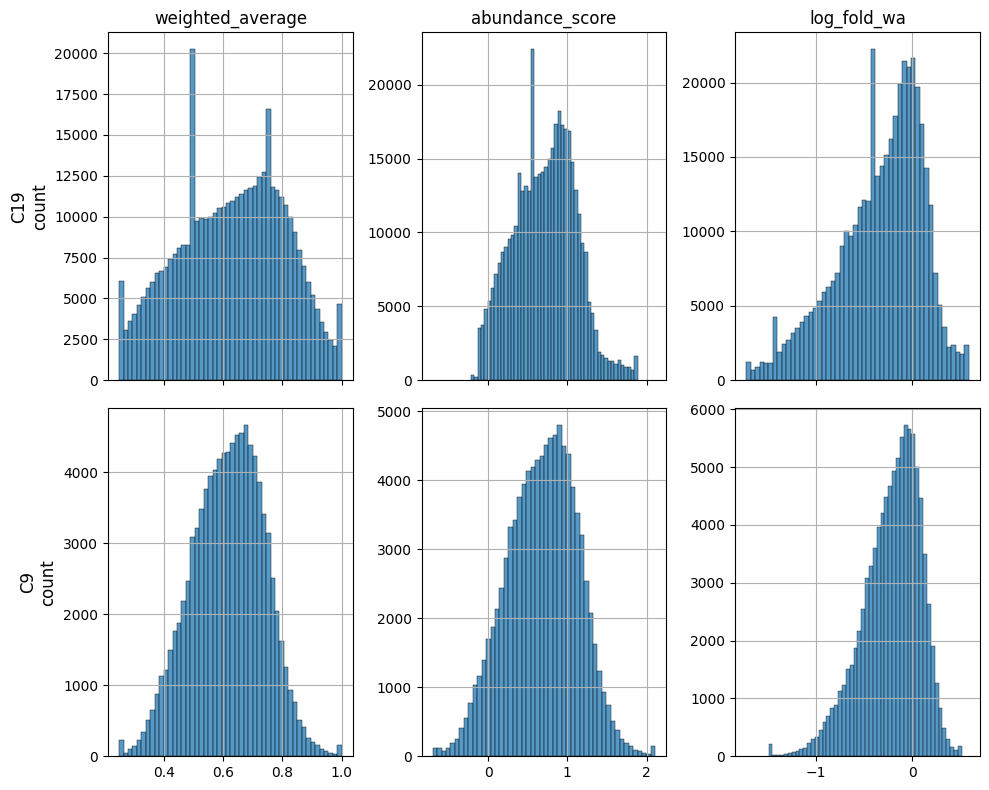

In [21]:
targets = ["weighted_average", "abundance_score", "log_fold_wa"]
fig, ax = plt.subplots(
    len(func_score_df.condition.unique()),
    len(targets),
    sharex="col",
    figsize=[10, 8]
)
for row, (condition, condition_df) in enumerate(func_score_df.groupby("condition")):
    for col, target in enumerate(targets):
        sns.histplot(condition_df, x=target, ax=ax[row, col], bins=50)
        ax[row, col].grid()
        ax[row, col].set_xlabel("")
        ax[row, col].set_ylabel("")
        if col == 0:
            ax[row, col].set_ylabel(f"{condition}\ncount", size=12)
        if row == 0:
            ax[row, col].set_title(target)
plt.tight_layout()
plt.show()

## Barcodes

First, we'll look at the number of barcodes per variant

In [22]:
for col, (condition, condition_df) in enumerate(func_score_df.groupby("condition")):
    vc = condition_df.aa_substitutions.value_counts()
    print(condition,'\n',vc.describe())

C19 
 count    8472.000000
mean       49.710458
std        64.122068
min         1.000000
25%        12.000000
50%        28.000000
75%        62.000000
max      1457.000000
Name: count, dtype: float64
C9 
 count    8308.000000
mean       11.780573
std        12.594819
min         1.000000
25%         4.000000
50%         8.000000
75%        14.000000
max       172.000000
Name: count, dtype: float64


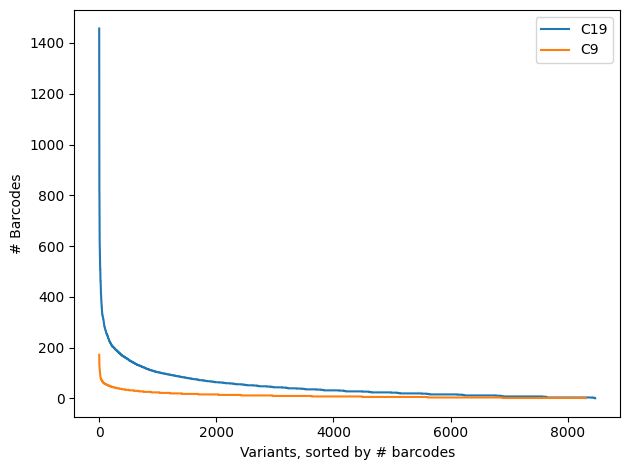

In [23]:
fig, ax = plt.subplots()
for col, (condition, condition_df) in enumerate(func_score_df.groupby("condition")):
    vc = condition_df.aa_substitutions.value_counts()
#     print(f"{condition} \n{vc[:5]}\n{vc[-5:]}")
    ax.plot(vc.values, label=condition)
    ax.set_ylabel("# Barcodes")
    ax.set_xlabel("Variants, sorted by # barcodes")
#     ax.set_title(condition)
ax.legend()
plt.tight_layout()
plt.show()

Next, let's look at the stoachasticity to expect by number of barcodes

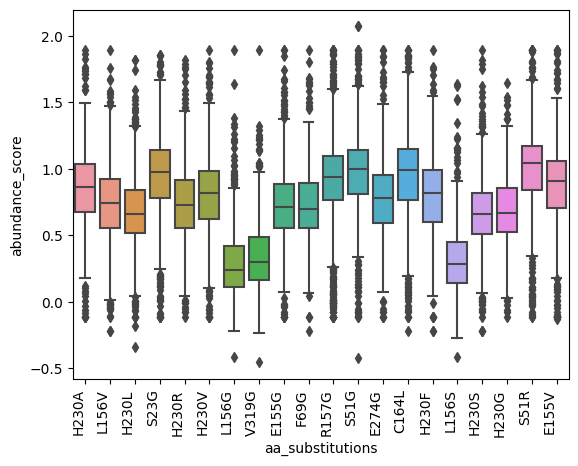

In [24]:
fig, ax = plt.subplots()
subs = func_score_df.aa_substitutions.value_counts()[:20].index
subs_fs = func_score_df.query(f"aa_substitutions.isin({list(subs)})")
sns.boxplot(subs_fs, x="aa_substitutions", y="abundance_score", ax=ax)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha='right')
plt.show()

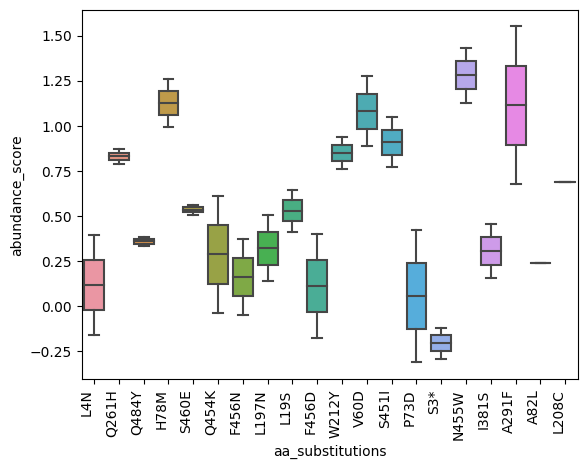

In [25]:
fig, ax = plt.subplots()
subs = func_score_df.aa_substitutions.value_counts()[-20:].index
subs_fs = func_score_df.query(f"aa_substitutions.isin({list(subs)})")
sns.boxplot(subs_fs, x="aa_substitutions", y="abundance_score", ax=ax)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha='right')
plt.show()

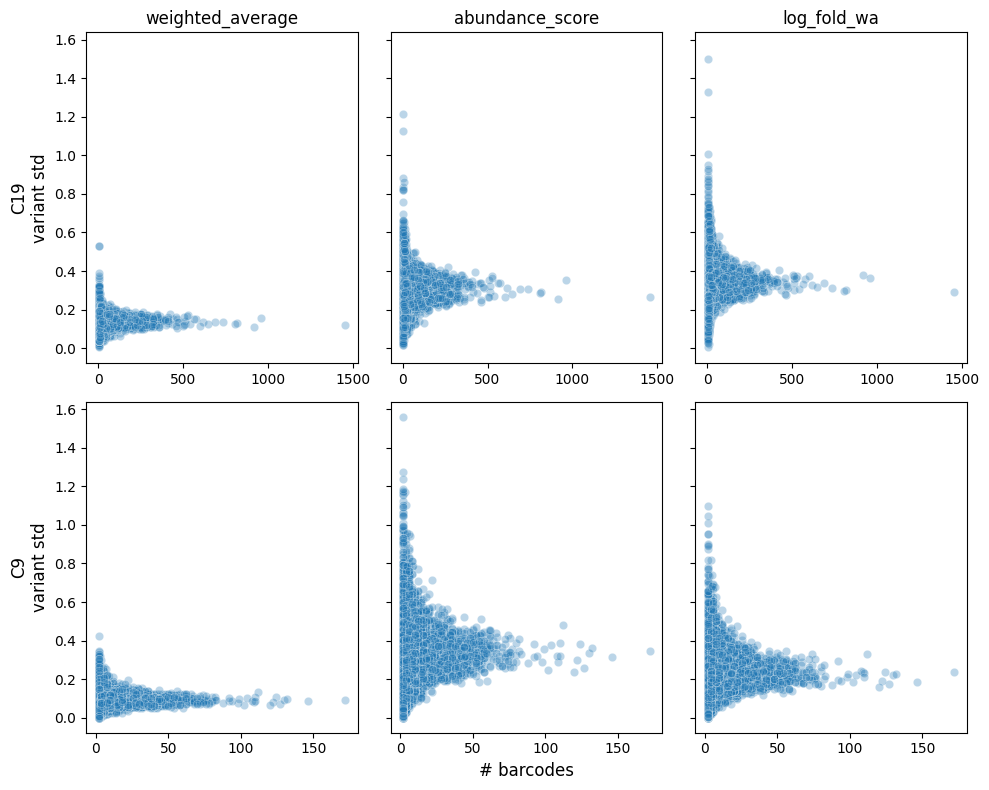

In [26]:
targets = ["weighted_average", "abundance_score", "log_fold_wa"]
fig, ax = plt.subplots(
    len(func_score_df.condition.unique()),
    len(targets),
    sharey=True,
    figsize=[10, 8]
)
for row, (condition, condition_df) in enumerate(func_score_df.groupby("condition")):
    for col, target in enumerate(targets):
        cv = condition_df.groupby("aa_substitutions").agg({"barcode":lambda x: len(x), target:onp.std})
        sns.scatterplot(cv,x="barcode", y=target, ax = ax[row, col], alpha=0.3)
        ax[row, col].set_xlabel("")
        ax[row, col].set_ylabel("")
        if col == 0:
            ax[row, col].set_ylabel(f"{condition}\nvariant std", size=12)
        if row == 0:
            ax[row, col].set_title(target)
        if row == 1 and col == 1:
            ax[row, col].set_xlabel("# barcodes", size=12)
plt.tight_layout()
plt.show()

## Fit individual replicates and asses shift correlation

In [41]:
func_score_df

,replicate,sort,barcode,weighted_average,total_reads,freq,type,med_nonsense,wt_wa,abundance_score,aa_substitutions,start,position,end,condition,log_fold_wa
0,Rep2,1.0,AAAAAAAACTACGTTCCA,0.844684,234,0.000008,missense,0.291621,0.826506,1.033983,S162R,S,162,R,C19,0.031385
1,Rep2,1.0,AAAAAAAATCCTAGCCGT,0.563894,937,0.000039,missense,0.291621,0.826506,0.509032,D373R,D,373,R,C19,-0.551601
2,Rep2,1.0,AAAAAAAATTTTGAAAGA,0.681836,959,0.000038,missense,0.291621,0.826506,0.729530,D360K,D,360,K,C19,-0.277602
3,Rep2,1.0,AAAAAAACTATTGACTTC,0.751838,217,0.000008,missense,0.291621,0.826506,0.860404,L71G,L,71,G,C19,-0.136604
4,Rep2,1.0,AAAAAAATACAGGTTAAT,0.304310,215,0.000017,nonsense,0.291621,0.826506,0.023724,E274*,E,274,X,C19,-1.441484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541398,Rep3,NaN,TTTTTTTTGAAAGTCAAG,0.706138,188,0.000070,missense,0.423188,0.701742,1.015779,K247A,K,247,A,C9,0.009008
541399,Rep3,NaN,TTTTTTTTGCCAACGAAG,0.647242,166,0.000065,missense,0.423188,0.701742,0.804345,D191T,D,191,T,C9,-0.116636
541400,Rep3,NaN,TTTTTTTTGTAATTCTTG,0.692603,103,0.000038,missense,0.423188,0.701742,0.967191,Q193L,Q,193,L,C9,-0.018912
541401,Rep3,NaN,TTTTTTTTGTACGTACTT,0.496281,104,0.000044,missense,0.423188,0.701742,0.262400,G332S,G,332,S,C9,-0.499785


In [42]:
target = "abundance_score"

In [54]:
OUTDIR="../results/abund_score_bothreps_beta_naught_lock_1/"
if not os.path.exists(OUTDIR): os.mkdir(OUTDIR)

In [43]:
rep_fits = pd.DataFrame()

for replicate, replicate_df in func_score_df.groupby("replicate"):

    data = multidms.Data(
        replicate_df.rename({target:"func_score"}, axis=1).reset_index(drop=True),
        reference = "C9",
        collapse_identical_variants = False,
        alphabet= multidms.AAS_WITHSTOP,
        verbose=True
    )

    for lock_beta_naught in [1., None]:

        data.condition_colors = {
            'C19': (0.0, 0.4470588235294118, 0.6980392156862745), 
            'C9': (0.0, 0.6196078431372549, 0.45098039215686275)
        }
        
        fit_params = {
            'epistatic_model' : "Identity",
            'output_activation' : "Identity",
            'lock_beta_naught' : lock_beta_naught,
            'init_beta_naught' : 0.,
            'gamma_corrected' : False,
            'warmup_beta':False,
            'save_model_at':[20000],
            'num_training_steps': 10,
            'iterations_per_step': 2000,
            'tol' : 1e-5,
            'scale_coeff_lasso_shift' : 1e-5,
            'scale_coeff_ridge_beta' : 1e-6
        }
        
        start_t = time.time()
        fit = multidms.utils.fit_wrapper(data, **fit_params)
        fit["beta_naught"] = "free" if lock_beta_naught is None else lock_beta_naught
        fit["replicate"] = replicate
        fit["target"] = target
        
        rep_fits = pd.concat([rep_fits, fit], ignore_index=True)
        end_t = time.time()
        print(f"FINISHED total time: {round(end_t - start_t)} seconds")

print(f"Done")

inferring site map for C19


  0%|          | 0/212375 [00:00<?, ?it/s]

inferring site map for C9


  0%|          | 0/48946 [00:00<?, ?it/s]

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [1, 221, 38, 236],
dropping: 190 variantswhich have mutations at those sites.


invalid non-identical-sites: [3, 50, 184, 206, 243, 295, 362], dropping 2986 variants
Converting mutations for C19


Converting mutations for C9
is reference, skipping
running:
{'PRNGKey': 0,
 'alpha_d': False,
 'data_idx': 0,
 'dataset': <multidms.data.Data object at 0x7f9a358ca890>,
 'epistatic_model': 'Identity',
 'gamma_corrected': False,
 'huber_scale_huber': 1,
 'init_beta_naught': 0.0,
 'iterations_per_step': 2000,
 'lock_beta': False,
 'lock_beta_naught': 1.0,
 'num_training_steps': 10,
 'output_activation': 'Identity',
 'save_model_at': [20000],
 'scale_coeff_lasso_shift': 1e-05,
 'scale_coeff_ridge_beta': 1e-06,
 'scale_coeff_ridge_ch': 0,
 'scale_coeff_ridge_gamma': 0,
 'scale_coeff_ridge_shift': 0,
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'tol': 1e-05,
 'warmup_beta': False}
training_step 0/10,Loss: 0.11354428351812842, Time: 74 Seconds
training_step 1/10,Loss: 0.08790624281487673, Time: 72 Seconds
training_step 2/10,Loss: 0.0823568698746258, Time: 71 Seconds
training_step 3/10,Loss: 0.0804147552322149, Time: 72 Seconds
training_step 4/10,Loss: 0.07953627107861123, 

  0%|          | 0/208772 [00:00<?, ?it/s]

inferring site map for C9


  0%|          | 0/48927 [00:00<?, ?it/s]

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [1, 221, 38, 236],
dropping: 191 variantswhich have mutations at those sites.


invalid non-identical-sites: [3, 50, 184, 206, 243, 295, 362], dropping 2962 variants
Converting mutations for C19


Converting mutations for C9
is reference, skipping
running:
{'PRNGKey': 0,
 'alpha_d': False,
 'data_idx': 0,
 'dataset': <multidms.data.Data object at 0x7f87e8e5aa10>,
 'epistatic_model': 'Identity',
 'gamma_corrected': False,
 'huber_scale_huber': 1,
 'init_beta_naught': 0.0,
 'iterations_per_step': 2000,
 'lock_beta': False,
 'lock_beta_naught': 1.0,
 'num_training_steps': 10,
 'output_activation': 'Identity',
 'save_model_at': [20000],
 'scale_coeff_lasso_shift': 1e-05,
 'scale_coeff_ridge_beta': 1e-06,
 'scale_coeff_ridge_ch': 0,
 'scale_coeff_ridge_gamma': 0,
 'scale_coeff_ridge_shift': 0,
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'tol': 1e-05,
 'warmup_beta': False}
training_step 0/10,Loss: 0.14739217078677552, Time: 70 Seconds
training_step 1/10,Loss: 0.12311969911160822, Time: 68 Seconds
training_step 2/10,Loss: 0.1183451624748087, Time: 68 Seconds
training_step 3/10,Loss: 0.11674503237960088, Time: 68 Seconds
training_step 4/10,Loss: 0.11603539664957162,

In [48]:
rep_fits

,dataset,huber_scale_huber,scale_coeff_lasso_shift,scale_coeff_ridge_beta,scale_coeff_ridge_shift,scale_coeff_ridge_gamma,scale_coeff_ridge_ch,data_idx,epistatic_model,output_activation,...,tol,num_training_steps,iterations_per_step,save_model_at,PRNGKey,step_loss,model_20000,beta_naught,replicate,target
0,<multidms.data.Data object at 0x7f9a358ca890>,1,0.00001,0.000001,0,0,0,0,Identity,Identity,...,0.00001,10,2000,[20000],0,"[0.11354428351812842, 0.08790624281487673, 0.0...",<multidms.model.Model object at 0x7f87e8b752d0>,1.0,Rep2,abundance_score
1,<multidms.data.Data object at 0x7f9a358ca890>,1,0.00001,0.000001,0,0,0,0,Identity,Identity,...,0.00001,10,2000,[20000],0,"[0.11085711460447012, 0.0872595995591526, 0.08...",<multidms.model.Model object at 0x7f87e8fe0210>,free,Rep2,abundance_score
2,<multidms.data.Data object at 0x7f87e8e5aa10>,1,0.00001,0.000001,0,0,0,0,Identity,Identity,...,0.00001,10,2000,[20000],0,"[0.14739217078677552, 0.12311969911160822, 0.1...",<multidms.model.Model object at 0x7f88beded2d0>,1.0,Rep3,abundance_score
3,<multidms.data.Data object at 0x7f87e8e5aa10>,1,0.00001,0.000001,0,0,0,0,Identity,Identity,...,0.00001,10,2000,[20000],0,"[0.14432811727459022, 0.12280329148001408, 0.1...",<multidms.model.Model object at 0x7f88bf537a50>,free,Rep3,abundance_score


1.0


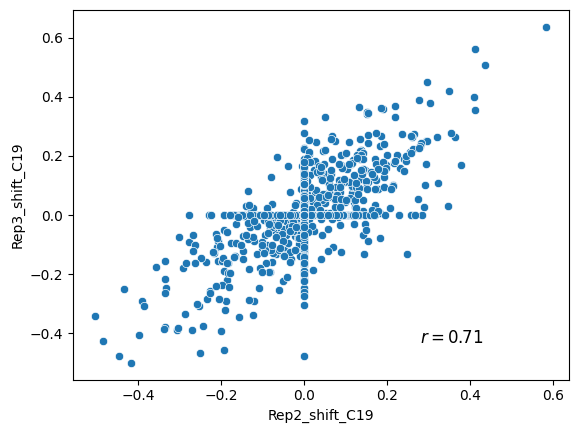

free


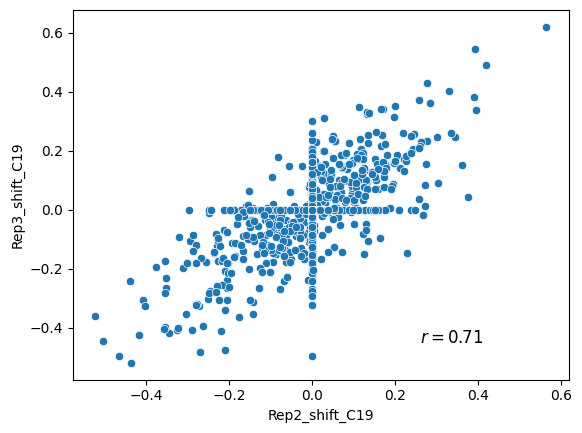

In [85]:
for beta_naught, fits in rep_fits.groupby("beta_naught"):
    print(beta_naught)
    
    fit_dict = {row.replicate:row.model_20000 for _, row in fits.iterrows()}
    combined_rep_mut_df = multidms.utils.combine_replicate_muts(fit_dict, times_seen_threshold=10)
    fig, ax = plt.subplots()
    r = pearsonr(combined_rep_mut_df["Rep2_shift_C19"], combined_rep_mut_df["Rep3_shift_C19"])[0]
    ax = sns.scatterplot(combined_rep_mut_df, x="Rep2_shift_C19", y="Rep3_shift_C19")
    ax.annotate(f"$r = {r:.2f}$", (0.7, 0.1), xycoords="axes fraction", fontsize=12)
    fig.savefig(f"{OUTDIR}/correlation_beta_naught_{beta_naught}.pdf")
    plt.show()

Rep2 1.0
{'alpha_C19': Array([0.], dtype=float64), 'alpha_C9': Array([0.], dtype=float64), 'beta': Array([-0.22531272,  0.17005502, -0.11450378, ..., -0.07549162,
       -0.12749275,  0.12198011], dtype=float64), 'beta_naught': Array([1.], dtype=float64), 'gamma_C19': Array([0.], dtype=float64), 'gamma_C9': Array([0.], dtype=float64), 'shift_C19': Array([ 0.00477917, -0.        ,  0.        , ...,  0.        ,
        0.        ,  0.        ], dtype=float64), 'shift_C9': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float64), 'theta': {'ghost_param': Array([0.], dtype=float64)}}


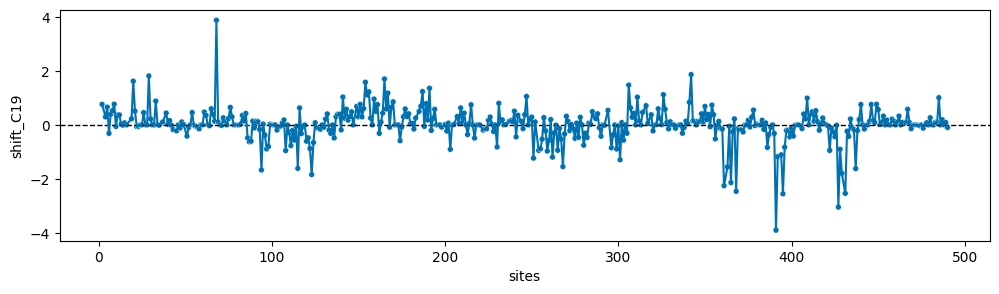

Rep2 free
{'alpha_C19': Array([0.], dtype=float64), 'alpha_C9': Array([0.], dtype=float64), 'beta': Array([0.10232748, 0.49110153, 0.21170292, ..., 0.2435423 , 0.17822033,
       0.41502147], dtype=float64), 'beta_naught': Array([0.66577112], dtype=float64), 'gamma_C19': Array([0.], dtype=float64), 'gamma_C9': Array([0.], dtype=float64), 'shift_C19': Array([ 0., -0.,  0., ...,  0.,  0.,  0.], dtype=float64), 'shift_C9': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float64), 'theta': {'ghost_param': Array([0.], dtype=float64)}}


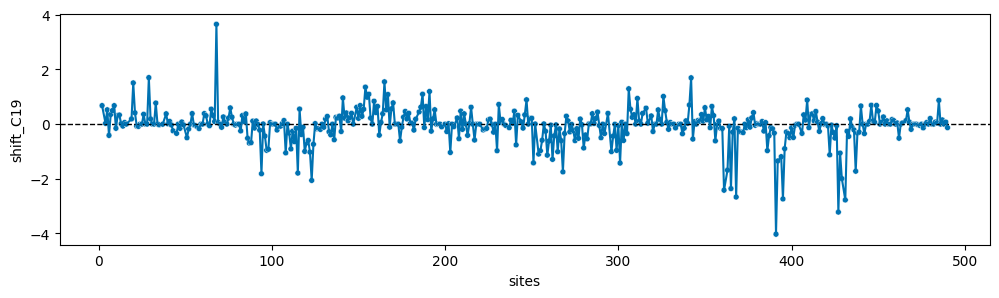

Rep3 1.0
{'alpha_C19': Array([0.], dtype=float64), 'alpha_C9': Array([0.], dtype=float64), 'beta': Array([-0.2029107 , -0.08209448,  0.04971902, ..., -0.02569589,
        0.0023704 ,  0.01119818], dtype=float64), 'beta_naught': Array([1.], dtype=float64), 'gamma_C19': Array([0.], dtype=float64), 'gamma_C9': Array([0.], dtype=float64), 'shift_C19': Array([ 0.,  0., -0., ...,  0.,  0.,  0.], dtype=float64), 'shift_C9': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float64), 'theta': {'ghost_param': Array([0.], dtype=float64)}}


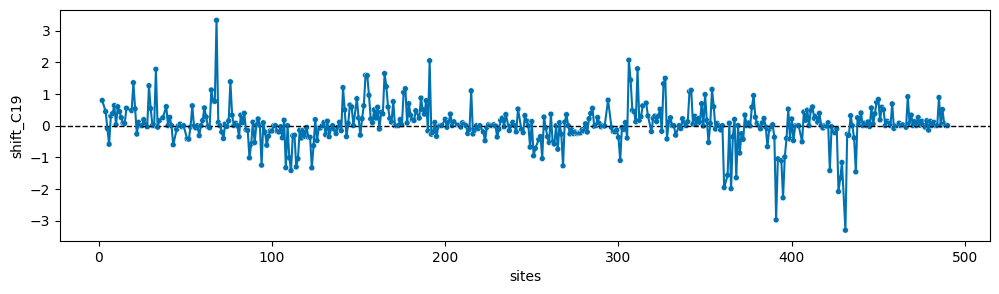

Rep3 free
{'alpha_C19': Array([0.], dtype=float64), 'alpha_C9': Array([0.], dtype=float64), 'beta': Array([0.1034944 , 0.21958323, 0.35652165, ..., 0.27425542, 0.28654245,
       0.28985868], dtype=float64), 'beta_naught': Array([0.68568822], dtype=float64), 'gamma_C19': Array([0.], dtype=float64), 'gamma_C9': Array([0.], dtype=float64), 'shift_C19': Array([ 0.,  0., -0., ...,  0.,  0.,  0.], dtype=float64), 'shift_C9': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float64), 'theta': {'ghost_param': Array([0.], dtype=float64)}}


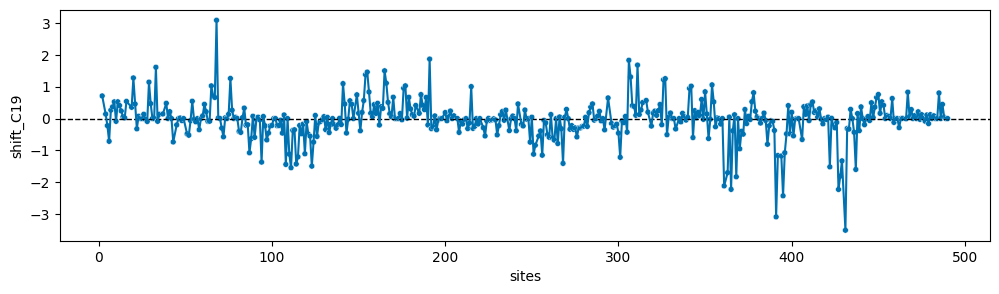

In [50]:
for idx, row in rep_fits.iterrows():
    print(row.replicate, row.beta_naught)
    print(row.model_20000.params)
    row.model_20000.plot_shifts_by_site("C19", times_seen_threshold=3, agg_func=onp.sum)

## Combine replicates, and shrinkage lasso params

In [51]:
data = multidms.Data(
    func_score_df.rename({target:"func_score"}, axis=1).reset_index(drop=True),
    reference = "C9",
    collapse_identical_variants = False,
    alphabet= multidms.AAS_WITHSTOP,
    verbose=True
)

inferring site map for C19


  0%|          | 0/421147 [00:00<?, ?it/s]

inferring site map for C9


  0%|          | 0/97873 [00:00<?, ?it/s]

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [1, 221, 38, 236],
dropping: 381 variantswhich have mutations at those sites.


invalid non-identical-sites: [3, 50, 184, 206, 243, 295, 362], dropping 5948 variants
Converting mutations for C19


Converting mutations for C9
is reference, skipping


In [52]:
models = pd.DataFrame()

In [53]:
data.condition_colors = {
    'C19': (0.0, 0.4470588235294118, 0.6980392156862745), 
    'C9': (0.0, 0.6196078431372549, 0.45098039215686275)
}
# choose fitting hyper-parameters
fit_params = {
    'init_beta_naught' : 1.0,
    'lock_beta_naught' : 1.0,
    'epistatic_model' : "Identity",
    'output_activation' : "Identity",
    'warmup_beta':False,
    'gamma_corrected':False,
    'alpha_d': True,
    'scale_coeff_ridge_beta':0,
    'scale_coeff_ridge_shift':0,
    'scale_coeff_ridge_gamma':0,
    'scale_coeff_ridge_ch':0,
    'tol':1e-4,
    'save_model_at':[30000],
    'num_training_steps': 30,
    'iterations_per_step':1000
}

for lasso in [0.0, 1e-06, 1e-05, 2e-05, 5e-05, 5e-4, 1e-4]:

    fit_params["scale_coeff_lasso_shift"] = lasso
    start_t = time.time()
    fit = multidms.utils.fit_wrapper(data, **fit_params)
    fit["target"] = "abundance_score"

    models = pd.concat([models, fit], ignore_index=True)
    end_t = time.time()
    print(f"FINISHED total time: {round(end_t - start_t)} seconds")

    print(f"Done")

running:
{'PRNGKey': 0,
 'alpha_d': True,
 'data_idx': 0,
 'dataset': <multidms.data.Data object at 0x7f87d0da7150>,
 'epistatic_model': 'Identity',
 'gamma_corrected': False,
 'huber_scale_huber': 1,
 'init_beta_naught': 1.0,
 'iterations_per_step': 1000,
 'lock_beta': False,
 'lock_beta_naught': 1.0,
 'num_training_steps': 30,
 'output_activation': 'Identity',
 'save_model_at': [30000],
 'scale_coeff_lasso_shift': 0.0,
 'scale_coeff_ridge_beta': 0,
 'scale_coeff_ridge_ch': 0,
 'scale_coeff_ridge_gamma': 0,
 'scale_coeff_ridge_shift': 0,
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'tol': 0.0001,
 'warmup_beta': False}
training_step 0/30,Loss: 0.28799416568639225, Time: 78 Seconds
training_step 1/30,Loss: 0.18913582468578097, Time: 73 Seconds
training_step 2/30,Loss: 0.15600958086953706, Time: 73 Seconds
training_step 3/30,Loss: 0.1387571115926004, Time: 73 Seconds
training_step 4

In [55]:
import pickle
pickle.dump(models, open(f"{OUTDIR}/models.pkl", "wb"))

In [56]:
models.loc[0, "model_30000"].data.reference

'C9'

In [57]:
data.condition_colors = {
    'C19': "#e694ae", 
    'C9': "#aad7da"
}

In [83]:
mut_df = multidms.utils.combine_replicate_muts(
    {
        f"lasso_{row.scale_coeff_lasso_shift}" : row.model_30000
        for idx, row in models.iterrows()   
    }
)

In [84]:
mut_df

,wts,sites,muts,lasso_0.0_beta,lasso_1e-06_beta,lasso_1e-05_beta,lasso_2e-05_beta,lasso_5e-05_beta,lasso_0.0005_beta,lasso_0.0001_beta,...,lasso_0.0001_C19_predicted_func_score,avg_C19_predicted_func_score,lasso_0.0_C9_predicted_func_score,lasso_1e-06_C9_predicted_func_score,lasso_1e-05_C9_predicted_func_score,lasso_2e-05_C9_predicted_func_score,lasso_5e-05_C9_predicted_func_score,lasso_0.0005_C9_predicted_func_score,lasso_0.0001_C9_predicted_func_score,avg_C9_predicted_func_score
mutation,,,,,,,,,,,,,,,,,,,,,
D2A,D,2,A,-0.265589,-0.260824,-0.216099,-0.217161,-0.217053,-0.217243,-0.217225,...,0.409458,0.317579,-0.265589,-0.260824,-0.216099,-0.217161,-0.217053,-0.217243,-0.217225,-0.230171
D2C,D,2,C,0.047939,0.054537,0.043316,0.042007,0.042201,0.041898,0.041911,...,0.668594,0.536128,0.047939,0.054537,0.043316,0.042007,0.042201,0.041898,0.041911,0.044830
D2E,D,2,E,-0.047888,-0.042483,-0.034592,-0.035540,-0.035431,-0.035612,-0.035596,...,0.591087,0.476691,-0.047888,-0.042483,-0.034592,-0.035540,-0.035431,-0.035612,-0.035596,-0.038163
D2F,D,2,F,-0.212537,-0.201055,-0.198747,-0.200018,-0.199499,-0.199980,-0.199948,...,0.426735,0.310522,-0.212537,-0.201055,-0.198747,-0.200018,-0.199499,-0.199980,-0.199948,-0.201683
D2G,D,2,G,-0.129917,-0.128078,-0.110375,-0.090864,-0.081273,-0.081510,-0.081483,...,0.545200,0.442595,-0.129917,-0.128078,-0.110375,-0.090864,-0.081273,-0.081510,-0.081483,-0.100500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V490N,V,490,N,-0.067686,-0.063195,-0.050088,-0.050380,-0.050482,-0.050455,-0.050461,...,0.576222,0.503137,-0.067686,-0.063195,-0.050088,-0.050380,-0.050482,-0.050455,-0.050461,-0.054678
V490P,V,490,P,-0.390620,-0.385318,-0.357173,-0.357930,-0.357762,-0.357967,-0.357952,...,0.268731,0.182274,-0.390620,-0.385318,-0.357173,-0.357930,-0.357762,-0.357967,-0.357952,-0.366389
V490R,V,490,R,-0.011695,-0.009186,-0.000425,-0.000582,-0.000563,-0.000594,-0.000591,...,0.626092,0.565413,-0.011695,-0.009186,-0.000425,-0.000582,-0.000563,-0.000594,-0.000591,-0.003377


In [60]:
mut_df.to_csv(f"{OUTDIR}/sweep_mut_df.csv")

In [61]:
models

,dataset,huber_scale_huber,scale_coeff_lasso_shift,scale_coeff_ridge_beta,scale_coeff_ridge_shift,scale_coeff_ridge_gamma,scale_coeff_ridge_ch,data_idx,epistatic_model,output_activation,...,init_beta_naught,warmup_beta,tol,num_training_steps,iterations_per_step,save_model_at,PRNGKey,step_loss,model_30000,target
0,<multidms.data.Data object at 0x7f87d0da7150>,1,0.0,0,0,0,0,0,Identity,Identity,...,1.0,False,0.0001,30,1000,[30000],0,"[0.28799416568639225, 0.18913582468578097, 0.1...",<multidms.model.Model object at 0x7f8820e90290>,abundance_score
1,<multidms.data.Data object at 0x7f87d0da7150>,1,0.000001,0,0,0,0,0,Identity,Identity,...,1.0,False,0.0001,30,1000,[30000],0,"[0.2884321917856809, 0.18958675125724944, 0.15...",<multidms.model.Model object at 0x7f8801ad2090>,abundance_score
2,<multidms.data.Data object at 0x7f87d0da7150>,1,0.00001,0,0,0,0,0,Identity,Identity,...,1.0,False,0.0001,30,1000,[30000],0,"[0.28976575965179496, 0.19039243051286758, 0.1...",<multidms.model.Model object at 0x7f88be377ad0>,abundance_score
3,<multidms.data.Data object at 0x7f87d0da7150>,1,0.00002,0,0,0,0,0,Identity,Identity,...,1.0,False,0.0001,30,1000,[30000],0,"[0.289191480825025, 0.1912003421810458, 0.1562...",<multidms.model.Model object at 0x7f87d110e490>,abundance_score
4,<multidms.data.Data object at 0x7f87d0da7150>,1,0.00005,0,0,0,0,0,Identity,Identity,...,1.0,False,0.0001,30,1000,[30000],0,"[0.2967333125417577, 0.19730263863246367, 0.15...",<multidms.model.Model object at 0x7f8809fefbd0>,abundance_score
5,<multidms.data.Data object at 0x7f87d0da7150>,1,0.0005,0,0,0,0,0,Identity,Identity,...,1.0,False,0.0001,30,1000,[30000],0,"[0.2977709916063878, 0.18695060979639697, 0.14...",<multidms.model.Model object at 0x7f88006f0f50>,abundance_score
6,<multidms.data.Data object at 0x7f87d0da7150>,1,0.0001,0,0,0,0,0,Identity,Identity,...,1.0,False,0.0001,30,1000,[30000],0,"[0.30340295636342796, 0.20372303476585735, 0.1...",<multidms.model.Model object at 0x7f8800bd6950>,abundance_score


In [62]:
# set some global variables
# columns name
model_name = "model_30000"

# the number of times a mutation must be seen in each condition to be included in downstream analysis
times_seen_threshold = 3

# The chosen lasso strength for our final spike model results
chosen_lasso_strength = 0.00001

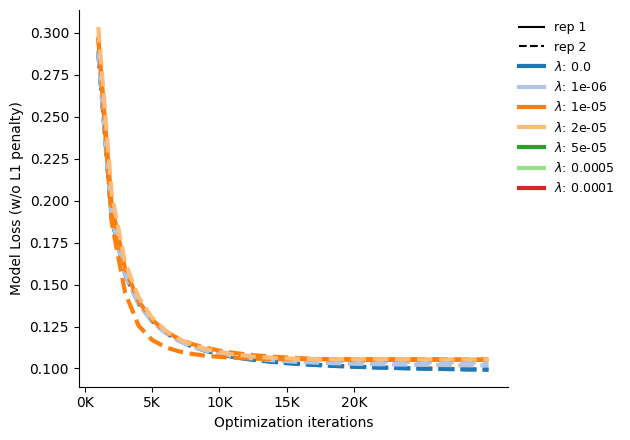

In [87]:
from matplotlib.lines import Line2D
import matplotlib.lines as mlines

saveas="convergence_all_lasso_lines"
cmap=plt.get_cmap("tab20")


fig, ax = plt.subplots(1,figsize=[6.4,4.5])
color_idx = -1
for i, (model, model_row) in enumerate(models.iterrows()):
    if i%2 == 0: color_idx += 1

    ax.plot(
        [1000 * (s+1) for s in range(len(model_row.step_loss))],
        model_row.step_loss,
        c=cmap.colors[color_idx],
        lw=3,
        linestyle="--",
        # linestyle="-" if model_row.replicate == 0 else "--",
        label=f"scale_coeff: {model_row.scale_coeff_lasso_shift}"
    )

ticks = range(0, 20001, 5000)
labels = [f"{t//1000}K" for t in ticks]
ax.set_xticks(ticks, labels, rotation=0, ha='center')
ax.set_ylabel("Model Loss (w/o L1 penalty)")
ax.set_xlabel("Optimization iterations")

black_line = mlines.Line2D([], [], color='black', linestyle='-',
                          markersize=5, label='rep 1')
black_dashed = mlines.Line2D([], [], color='black',linestyle='--',
                          markersize=5, label='rep 2')
lasso_color_handles = [
    mlines.Line2D(
        [], [], 
        color=color, 
        linestyle='-',
        markersize=5,
        linewidth=3,
        label="$\lambda$: "+str(lasso)
    )
    for lasso, color in zip(models.scale_coeff_lasso_shift.unique(), cmap.colors)
]

elements = [black_line, black_dashed] + lasso_color_handles
ax.legend(handles=elements, bbox_to_anchor = (1, 1), loc='upper left', frameon=False, fontsize=9)
sns.despine(ax=ax)
ax.set_ylim()
plt.tight_layout()
fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
plt.show()

In [93]:
models = models.sort_values("scale_coeff_lasso_shift").reset_index(drop=True)

0.0
1e-06
1e-05
2e-05
5e-05
0.0001
0.0005


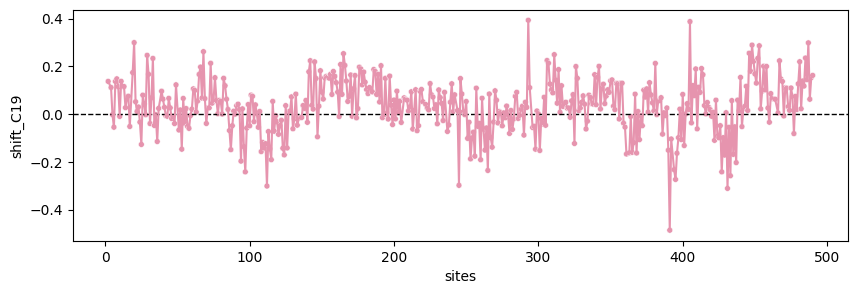

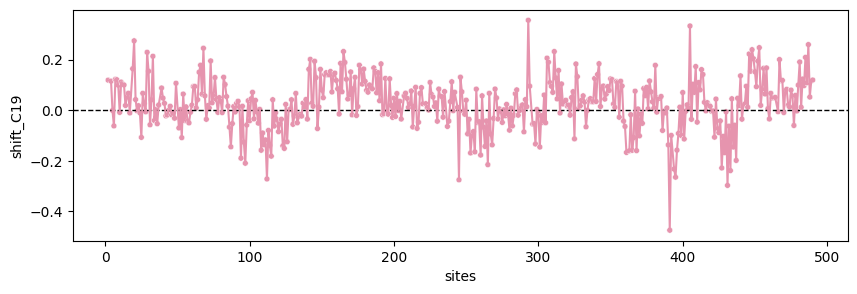

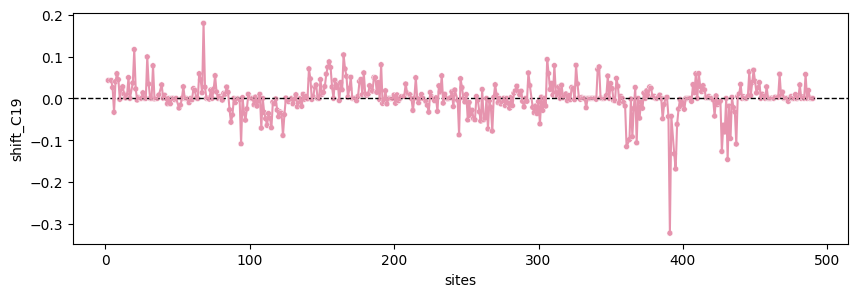

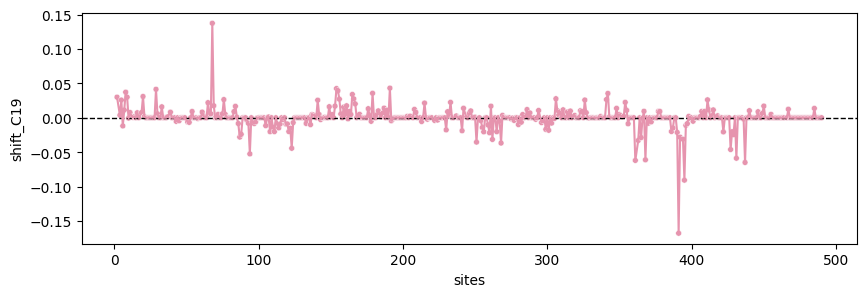

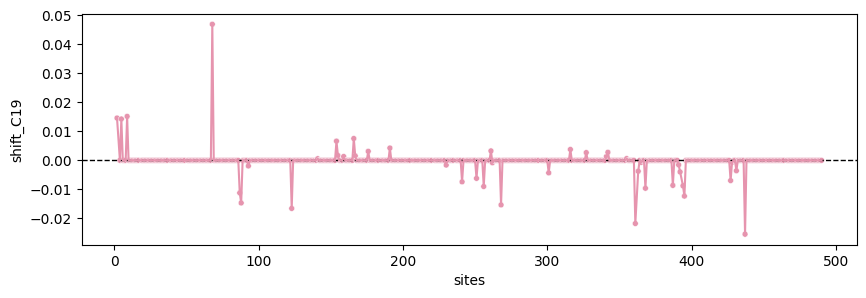

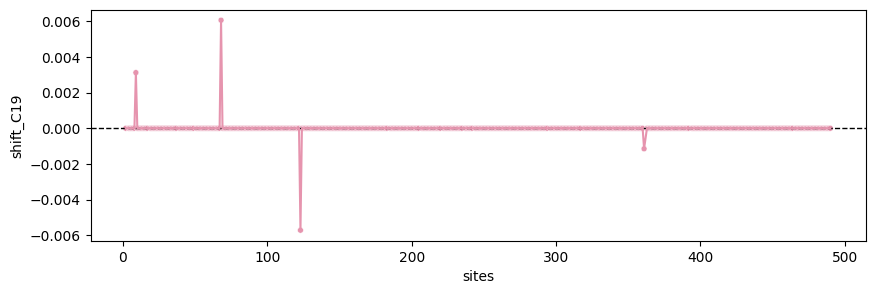

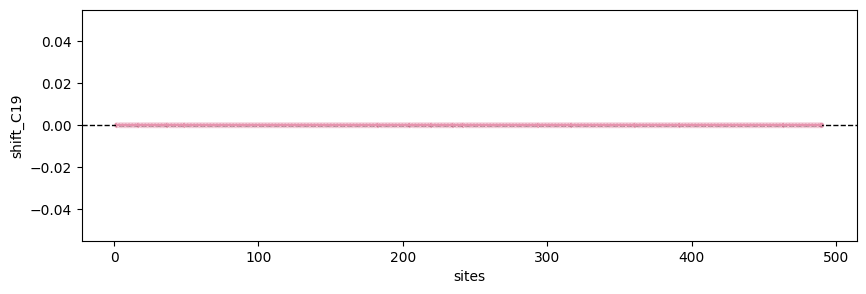

In [94]:
for idx, model in models.iterrows():
    fig, ax = plt.subplots(figsize=(10, 3))
    print(model.scale_coeff_lasso_shift)
    model[model_name].plot_shifts_by_site(
        "C19", 
        times_seen_threshold=times_seen_threshold, 
        agg_func=onp.mean,
        show=False,
        ax=ax
    )
    fig.savefig(f"{OUTDIR}/shifts_by_site_lasso_{model.scale_coeff_lasso_shift}.pdf")

In [95]:
fit_dict = {f"l_{float(row.scale_coeff_lasso_shift)}":row[model_name] for _, row in models.iterrows()}

mut_df = multidms.utils.combine_replicate_muts(
    fit_dict, 
    times_seen_threshold=times_seen_threshold, 
    how="outer"
)

mut_df = pd.melt(
    mut_df.reset_index(), 
    id_vars=["mutation"],
    value_vars=[
        col for col in mut_df.columns 
        if ("_shift_" in col or "beta" in col) and "avg" not in col
    ],
    value_name="S"
)

mut_df = mut_df.assign(
    scale_coeff_lasso=[ 
        v.split("_")[1]
        for v in mut_df.variable
    ],
    sense=[
        "stop" if "*" in mut else "nonsynonymous"
        for mut in mut_df.mutation
    ],
    condition=[
        "C9" 
        if "beta" in v
        else "C19" 
        for v in mut_df.variable
    ],
    # replicate=replicate
)

mut_df.drop("variable", axis=1, inplace=True)
tall_mut_df = mut_df

In [96]:
tall_mut_df

,mutation,S,scale_coeff_lasso,sense,condition
0,D2A,-0.265589,0.0,nonsynonymous,C9
1,D2C,0.047939,0.0,nonsynonymous,C9
2,D2E,-0.047888,0.0,nonsynonymous,C9
3,D2F,-0.212537,0.0,nonsynonymous,C9
4,D2G,-0.129917,0.0,nonsynonymous,C9
...,...,...,...,...,...
85465,V490N,0.000000,0.0005,nonsynonymous,C19
85466,V490P,0.000000,0.0005,nonsynonymous,C19
85467,V490R,0.000000,0.0005,nonsynonymous,C19
85468,V490S,-0.000000,0.0005,nonsynonymous,C19


In [97]:
import jax
def loss(model, condition):
    kwargs = {
        'scale_coeff_ridge_beta': 0.,
        'scale_coeff_ridge_shift': 0.,
        'scale_coeff_ridge_gamma': 0.
    }
    
    data = (
        {condition:model.data.training_data["X"][condition]}, 
        {condition:model.data.training_data["y"][condition]}
    )
    
    params = model.get_condition_params(condition)
    return jax.jit(model._model_components["objective"])(model.params, data)

lasso_sparsity_loss = defaultdict(list)
for lasso, lasso_replicates in models.groupby("scale_coeff_lasso_shift"):
    lasso_sparsity_loss["lasso"].append(str(lasso))
    model = lasso_replicates[model_name].values[0]
    muts_df_outer = model.get_mutations_df(phenotype_as_effect=False)
    muts_df_outer = muts_df_outer.assign(
        sense = [
            "stop" if "*" in mut else "nonsynonymous"
            for mut in muts_df_outer.index.values
        ]
    )

    muts_df_inner = muts_df_outer.dropna()
    for cond in model.data.conditions:
        if cond == model.data.reference:

            rep_cond_shifts = muts_df_outer[[f"beta", "sense"]].dropna()
            for sense, color in zip(["stop", "nonsynonymous"], ["red", "blue"]):
                shifts = rep_cond_shifts.query("sense == @sense")[f"beta"]
                sparsity = (len(shifts[onp.isclose(shifts, 0, 1e-8)]) / len(shifts))*100
                lasso_sparsity_loss[f"{cond}-{sense}-sparsity"].append(sparsity)

        else:
            
            rep_cond_shifts = muts_df_outer[[f"shift_{cond}", "sense"]].dropna()
            for sense, color in zip(["stop", "nonsynonymous"], ["red", "blue"]):
                shifts = rep_cond_shifts.query("sense == @sense")[f"shift_{cond}"]
                sparsity = (len(shifts[onp.isclose(shifts, 0, 1e-8)]) / len(shifts))*100
                lasso_sparsity_loss[f"{cond}-{sense}-sparsity"].append(sparsity)
            

        lasso_sparsity_loss[f"{cond}-loss"].append(loss(model, cond))

lasso_sparsity_loss = pd.DataFrame(lasso_sparsity_loss)
lasso_sparsity_loss

,lasso,C19-stop-sparsity,C19-nonsynonymous-sparsity,C19-loss,C9-stop-sparsity,C9-nonsynonymous-sparsity,C9-loss
0,0.0,21.844660,9.069320,0.04704641371146149,0.0,0.0,0.05229316655967709
1,1e-06,27.184466,14.395567,0.04710629368613049,0.0,0.0,0.05222623209805232
2,1e-05,85.194175,77.190999,0.04876867152067491,0.0,0.0,0.05308114350607266
3,2e-05,96.601942,93.633382,0.04951449556858508,0.0,0.0,0.053978158864422005
4,5e-05,100.000000,99.332806,0.050257932702955956,0.0,0.0,0.054872370922138744
5,0.0001,100.000000,99.954766,0.0503665206320586,0.0,0.0,0.05499502968601528
6,0.0005,100.000000,100.000000,0.05038509351215354,0.0,0.0,0.0550181146148734


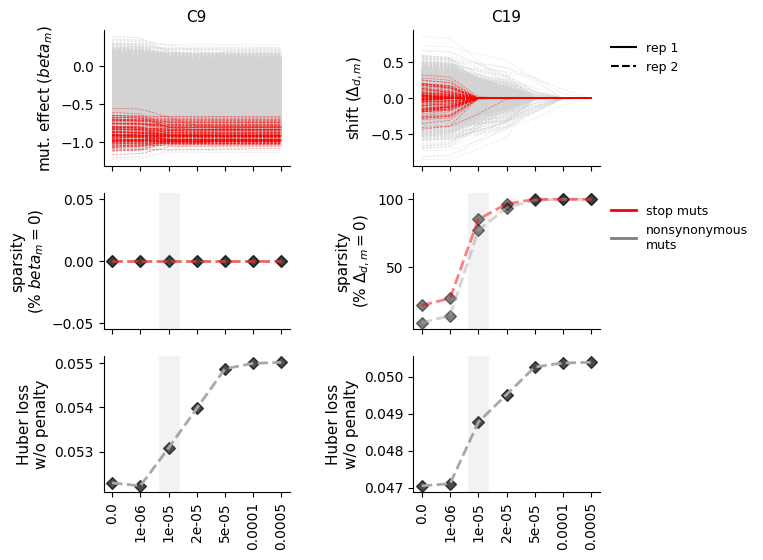

In [99]:
saveas="shrinkage_analysis_trace_plots_beta"
fig, ax = plt.subplots(
    3,3, 
    figsize=[6.4,6],
    sharex=True, 
    gridspec_kw={
        'width_ratios': [1,0.35,1]
    }
)

lasso_cmap=plt.get_cmap("Set2").colors
lasso_shrinkage = sorted(models.scale_coeff_lasso_shift.unique())
lasso_shrinkage_cmap = dict(zip(lasso_shrinkage, lasso_cmap))

# mutations_to_highlight = ["D142L", "A419S", "A570D", "K854N", "T1027I"]
# mutations_cmap=plt.get_cmap("Accent").colors
# mutations_cmap = dict(zip(mutations_to_highlight, mutations_cmap))

condition_col = {
    "C9" : 0,
    "C19" : 2,
}

replicate_line_style = {
    0 : "-",
    1 : "--"
}

replicate_marker = {
    0 : "o",
    1 : "D"
}

sense_colors = {
    "nonsynonymous" : "darkgrey",
    "stop" : "red"
}

sense_lw = {
    "nonsynonymous" : 0.5,
    "stop" : 0.5
}

sense_alpha = {
    "nonsynonymous" : 0.5,
    "stop" : 0.5
}

model_choice = chosen_lasso_strength
model_line_kwargs = {
    "linewidth" : 15,
    "color" : "grey",
    "alpha" : 0.1
}

for condition, df in tall_mut_df.groupby("condition"):
    replicate=1
    row = 0
    iter_ax = ax[row, condition_col[condition]]
    sns.despine(ax=iter_ax)
    
    # plot nonsynonymous, non validated
    for mut, trace_df in df.query(
        "sense == 'nonsynonymous'"
    ).groupby("mutation"):
        iter_ax.plot(
            trace_df.scale_coeff_lasso, 
            trace_df.S,
            linestyle=replicate_line_style[replicate],
            linewidth=sense_alpha['nonsynonymous'],
            alpha=sense_alpha['nonsynonymous'],
            color="lightgrey"
        )
    
    # plot stop traces
    for mut, trace_df in df.query("sense == 'stop'").groupby("mutation"):

        iter_ax.plot(
            trace_df.scale_coeff_lasso, 
            trace_df.S,
            linestyle=replicate_line_style[replicate],
            linewidth=sense_lw['stop'],
            alpha=sense_alpha['stop'],
            color=sense_colors['stop']
        )

    # # plot highlighted muts
    # for mut, trace_df in df.query(
    #     "mutation.isin(@mutations_to_highlight)"
    # ).groupby("mutation"):
    #     iter_ax.plot(
    #         trace_df.scale_coeff_lasso, 
    #         trace_df.S,
    #         linestyle=replicate_line_style[replicate],
    #         linewidth=2,
    #         alpha=1.0,
    #         color=mutations_cmap[mut]
    #     )
    # iter_ax.axvline(str(model_choice), **model_line_kwargs)
    
        
    # Plot sparsity    
    row = 1
    iter_ax = ax[row, condition_col[condition]]
    sns.despine(ax=iter_ax)
    
    for sense in ["nonsynonymous", "stop"]:
        iter_ax.plot(
            lasso_sparsity_loss["lasso"],
            lasso_sparsity_loss[f"{condition}-{sense}-sparsity"],
            linestyle=replicate_line_style[replicate],
            linewidth=2,
            alpha=0.5,
            color=sense_colors[sense]
        )
        
        iter_ax.scatter(
            lasso_sparsity_loss["lasso"],
            lasso_sparsity_loss[f"{condition}-{sense}-sparsity"],
            marker=replicate_marker[replicate],
            alpha=0.5,
            color="black"
        )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)
        
    # Plot Loss  
    row = 2
    iter_ax = ax[row, condition_col[condition]]
    sns.despine(ax=iter_ax)
    
    
    iter_ax.plot(
        lasso_sparsity_loss["lasso"],
        lasso_sparsity_loss[f"{condition}-loss"],
        linestyle=replicate_line_style[replicate],
        linewidth=2,
        alpha=1.0,
        color="darkgrey"
    )

    iter_ax.scatter(
        lasso_sparsity_loss["lasso"],
        lasso_sparsity_loss[f"{condition}-loss"],
        marker=replicate_marker[replicate],
        alpha=0.7,
        color="black"
    )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)



ax[0, 0].set_title("C9", size=11)
ax[0, 2].set_title("C19", size=11)
# ax[0, 3].set_title("BA.2", size=11)

ax[0, 1].set_visible(False)
ax[1, 1].set_visible(False)
ax[2, 1].set_visible(False)

ax[0, 0].set_ylabel("mut. effect ($beta_{m}$)", size=11)
ax[1, 0].set_ylabel("sparsity\n(% $beta_{m} = 0$)", size=11)
# ax[2, 0].set_ylabel("condition\n train data loss \n$L_{Huber_{\sigma=1}}^{d}$ w/o penalty", size=11)
# ax[2, 0].set_ylabel("condition\n training data loss", size=11)
ax[2, 0].set_ylabel("Huber loss\nw/o penalty", size=11)
# ax[3, 0].set_ylabel("$r(beta_{m}^{rep1},beta_{m}^{rep2})$", size=11)

ax[0, 2].set_ylabel("shift $(\Delta_{d,m})$", size=11)
ax[1, 2].set_ylabel("sparsity\n(% $\Delta_{d,m} = 0$)", size=11)
# ax[2, 2].set_ylabel("Huber loss\n w/o penalty", size=11)
ax[2, 2].set_ylabel("Huber loss\nw/o penalty", size=11)
# ax[2, 0].set_ylabel("condition\n training data loss", size=11)



# TODO legends
black_line = mlines.Line2D([], [], color='black', linestyle='-',
                          markersize=5, label='rep 1')
black_dashed = mlines.Line2D([], [], color='black',linestyle='--',
                          markersize=5, label='rep 2')
# lasso_color_handles = [
#     mlines.Line2D(
#         [], [], 
#         color=color, 
#         linestyle='-',
#         markersize=2,
#         linewidth=2,
#         label=mut
#     )
#     for mut, color in mutations_cmap.items()
# ]

elements = [black_line, black_dashed] 
ax[0,2].legend(handles=elements, bbox_to_anchor = (1, 1), loc='upper left', frameon=False, fontsize=9)

black_circle = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                          markersize=5, label='rep 1')
black_triangle = mlines.Line2D([], [], color='black', marker='D', linestyle='None',
                          markersize=5, label='rep 2')

red_line = mlines.Line2D([], [], color='red', linewidth=2,linestyle='-',markersize=5, label='stop muts')
grey_line = mlines.Line2D([], [], color='grey',linewidth=2, linestyle='-',markersize=5, label='nonsynonymous\nmuts')

elements = [red_line, grey_line] #+lasso_color_handles
ax[1, 2].legend(handles=elements, bbox_to_anchor = (1, 1), loc='upper left', frameon=False, fontsize=9)


# ax[0,0].text(
#     -0.55, 1.00, 
#     f"A", 
#     ha="right", va="center", 
#     size=15,
#     weight="bold",
#     transform=ax[0,0].transAxes
# )
# ax[1,0].text(
#     -0.55, 1.00, 
#     f"B", 
#     ha="right", va="center", 
#     size=15,
#     weight="bold",
#     transform=ax[1,0].transAxes
# )
# ax[2,0].text(
#     -0.55, 1.00, 
#     f"C", 
#     ha="right", va="center", 
#     size=15,
#     weight="bold",
#     transform=ax[2,0].transAxes
# )

# ax[0, 2].set_yticks([-2.5, 0, 2.5], [-2.5, 0, 2.5])
# ax[0, 2].set_ylim([-3.0, 4.5])
# ax[0, 3].set_yticks([-2.5, 0, 2.5], [-2.5, 0, 2.5])
# ax[0, 3].set_ylim([-3.0, 4.5])
# ax[0, 3].yaxis.set_tick_params(labelleft=False)

# ax[1, 2].set_yticks([0, 50, 100], [0, 50, 100])
# ax[1, 2].set_ylim([-5, 105])
# ax[1, 3].set_yticks([0, 50, 100], [0, 50, 100])
# ax[1, 3].set_ylim([-5, 105])
# ax[1, 3].yaxis.set_tick_params(labelleft=False)

# ax[2, 2].set_yticks([.1, .2, .3], [.1, .2, .3])
# ax[2, 2].set_ylim([.15, .35])
# ax[2, 3].set_yticks([.1, .2, .3], [.1, .2, .3])
# ax[2, 3].set_ylim([.15, .35])
# ax[2, 3].yaxis.set_tick_params(labelleft=False)

ax[2,0].set_xticks(ax[2,0].get_xticks(), ax[2,0].get_xticklabels(), rotation=90, ha='center')
ax[2,2].set_xticks(ax[2,2].get_xticks(), ax[2,2].get_xticklabels(), rotation=90, ha='center')

# plt.tight_layout()
fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
plt.show()